In [3]:
import cv2
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
import cv2
import numpy as np

# For Images

In [4]:
# Load the MTCNN model
detector = MTCNN()
# Load the model
model = YOLO('yolov8s.pt')
# Load an image
image_path = r"C:\Users\karim\Desktop\image (2).jpg"
image = cv2.imread(image_path)



In [5]:
def resize_image_and_adjust_coordinates(image, bounding_boxes, left_eye, right_eye, target_width=None, target_height=None):
    original_height, original_width = image.shape[:2]
    if target_width is not None and target_height is not None:
        scaling_factor = min(target_width / original_width, target_height / original_height)
    elif target_width is not None:
        scaling_factor = target_width / original_width
    elif target_height is not None:
        scaling_factor = target_height / original_height
    else:
        raise ValueError("Either target_width or target_height must be provided.")
    
    new_width = int(original_width * scaling_factor)
    new_height = int(original_height * scaling_factor)
    resized_image = cv2.resize(image, (new_width, new_height))
    adjusted_bounding_boxes = [(int(x1 * scaling_factor), int(y1 * scaling_factor), int(x2 * scaling_factor), int(y2 * scaling_factor)) for (x1, y1, x2, y2) in bounding_boxes]
    adjusted_left = [int(x * scaling_factor) for x in left_eye]
    adjusted_right = [int(x * scaling_factor) for x in right_eye]
    return resized_image, adjusted_bounding_boxes, adjusted_left, adjusted_right

def draw_bounding_boxes(results, image, left_eye, right_eye, target_width):
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Extract bounding boxes in (x1, y1, x2, y2) format
        confidences = result.boxes.conf.cpu().numpy()  # Extract confidence scores
        class_ids = result.boxes.cls.cpu().numpy()  # Extract class IDs
        resized_image, adjusted_bounding_boxes, adjusted_left, adjusted_right = resize_image_and_adjust_coordinates(image, boxes, left_eye, right_eye, target_width=target_width)
        for box, confidence, class_id in zip(adjusted_bounding_boxes, confidences, class_ids):
            if int(class_id) == 0:  # Assuming Class ID 0 corresponds to 'person'
                x1, y1, x2, y2 = map(int, box)
                for left_, right_ in zip(adjusted_left, adjusted_right):
                    if left_ > x1 and right_ < x2:
                        cv2.rectangle(resized_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        height = 6.5 * (y2 - y1 + 10) / (right_ - left_ + 1) + 20
                        cv2.putText(resized_image, f'{height:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
    return resized_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

0: 384x640 4 persons, 1 sports ball, 911.5ms
Speed: 7.0ms preprocess, 911.5ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


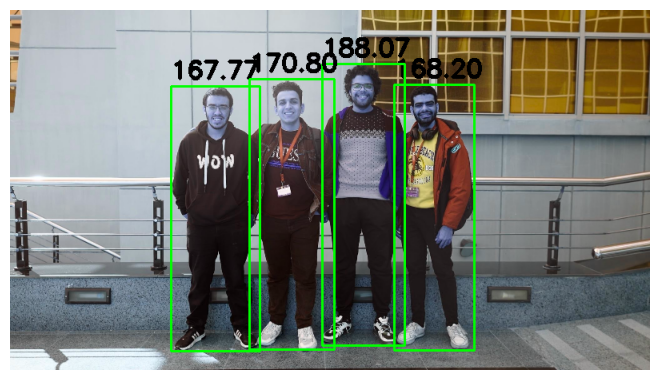

In [6]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
min_confidence = 0.85
target_width = 800
left_eye = []
right_eye = []
draw_image = image.copy()
# Loop through detected faces
for face in faces:
    if face['confidence'] >= min_confidence:
        keypoints = face['keypoints']
        left_eye.append(keypoints['left_eye'][0])
        right_eye.append(keypoints['right_eye'][0])
# Function to resize image and adjust coordinates

results = model(image)  # Assume you have a model function for detection
processed_frame = draw_bounding_boxes(results, image, left_eye, right_eye, target_width)


fig, ax = plt.subplots()
# Display the image
ax.imshow(processed_frame)
# Remove axes
ax.axis('off')
# Set the figure background to transparent to remove any possible white space
fig.patch.set_visible(False)
# Adjust layout to remove any padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.margins(0, 0)  # Remove any margins
# Show the image in cell output
plt.show()

# Display the processed frame in new window
cv2.imshow('Processed Image', processed_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


# For Videos

In [ ]:
import cv2

# Initialize video capture (0 for default camera, or provide the path to your video file)
cap = cv2.VideoCapture(0)  # or cv2.VideoCapture('path_to_your_video.mp4')

min_confidence = 0.85
target_width = 800  # Example target width for display
save = False
# Define the video codec and create a VideoWriter object to save the processed video (optional)
if save:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect faces in the frame
    faces = detector.detect_faces(frame_rgb)
    
    left_eye = []
    right_eye = []
    
    for face in faces:
        if face['confidence'] >= min_confidence:
            keypoints = face['keypoints']
            left_eye.append(keypoints['left_eye'][0])
            right_eye.append(keypoints['right_eye'][0])
    
    # Process the frame and draw bounding boxes
    results = model(frame_rgb)  # Assume you have a model function for detection
    processed_frame = draw_bounding_boxes(results, frame, left_eye, right_eye, target_width)
    
    # Display the processed frame
    cv2.imshow('Processed Video', processed_frame)
    
    # Write the processed frame to the output video file (optional)
    if save:
        out.write(processed_frame)
    
    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and writer objects
cap.release()
out.release()
cv2.destroyAllWindows()
